# Comparison of Models

Some imports

In [33]:
import os
from tqdm import tqdm
import sklearn
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn import tree
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from IPython.display import Image 
import pydotplus
import numpy as np
import pandas as pd

Utility function

In [48]:
# Function to create a tree diagram
def create_tree_graph_png(tree, feature_names):
    tree_str = export_graphviz(tree, feature_names=feature_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    try:
        graph.write_png('ml-project/media/tree.png')
    except:
        pass
    return Image(graph.create_png())

def rae(price_test, price_preds):
    numerator = np.sum(np.abs(price_preds - price_test))
    denominator = np.sum(np.abs(np.mean(price_test) - price_test))
    return numerator / denominator

def error_plot(y_train, y_train_pred, y_test, y_test_pred):
    error_train = y_train - y_train_pred
    error_test = y_test - y_test_pred

    Q = np.quantile(error_test, [0.25, 0.75])
    print('Quantile 1 : ', round(Q[0], 2), ' euros')
    print('Quantile 3 : ', round(Q[1], 2), ' euros')

    plt.scatter(y_train, error_train, s=2)
    plt.scatter(y_test, error_test, s=2)
    plt.legend(["Train", "Test"])
    plt.xlabel("Price")
    plt.ylabel("Error")
    plt.rcParams["figure.figsize"] = (5, 3)
    plt.show()

def plot_metrics(model, X_train_tot, y_train_tot, X_test, y_test):
    model.fit(
        X_train_tot,
        y_train_tot
    )
    y_train_pred = model.predict(X_train_tot)
    y_test_pred = model.predict(X_test)
    print("Mean Squared Error: ", round(mean_squared_error(y_test, y_test_pred), 2))
    print(f"Mean Absolute Error: {round(mean_absolute_error(y_test, y_test_pred), 2)} €")
    print("Relative Absolute Error: ", round(rae(y_test, y_test_pred), 3)*100, "%")
    error_plot(y_train_tot, y_train_pred, y_test, y_test_pred)

Loading dataset

Train set 9772 | Val set 2443 | Test set 3054


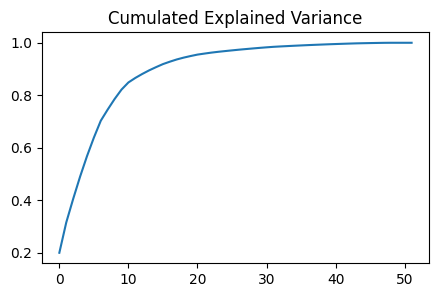

In [77]:
data_train = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_train.csv")
data_val = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_val.csv")
data_test = pd.read_csv("/Users/cha/Desktop/3A/code/ml-project/data/data_test.csv")
print("Train set", len(data_train), "| Val set", len(data_val), "| Test set", len(data_test))

# Best features selected in dimensionality reduction part
features = [
    "Accomodates",
    "Bathrooms",
    "Bedrooms",
    "Beds",
    "Guests Included",
    "Property Type_Hotel",
    "Property Type_Apartment",
    # "Property Type_Serviced apartment",
    "Room Type_Entire home/apt",
    "dist_to_center",
    "Host Response Time",
    "Neighborhood Group_Charlottenburg-Wilm."
]

X_train_best_feat = data_train[features]
y_train = data_train['Price']
X_val_best_feat = data_val[features]
y_val = data_val['Price']
X_test_best_feat = data_test[features]
y_test = data_test['Price']

# PCA reduction
pca = PCA()
columns = list(data_train.columns)
columns.remove("Price")
X_train_pca = pca.fit_transform(data_train[columns])
y_train = data_train['Price']
X_val_pca = pca.transform(data_val[columns])
y_val = data_val['Price']
X_test_pca = pca.transform(data_test[columns])
y_test = data_test['Price']

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulated Explained Variance")
plt.show()

In [78]:
from sklearn.linear_model import LinearRegression

X_train_pca = X_train_pca[:, :10]
X_val_pca = X_train_pca[:, :10]
X_test_pca = X_train_pca[:, :10]

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
score_pca = -1*model_selection.cross_val_score(
    regr,
    X_train_pca,
    y_train.ravel(),
    cv=kf_10,
    scoring='neg_mean_squared_error'
).mean()

score_best_features = -1*model_selection.cross_val_score(
    regr,
    X_train_best_feat,
    y_train.ravel(),
    cv=kf_10,
    scoring='neg_mean_squared_error'
).mean()
print(score_pca, score_best_features)

1882.016365905989 1553.4917312243863


Using the best-feature selection as the dimensionality reduction method

In [79]:
X_train = X_train_best_feat
X_val = X_val_best_feat
X_test = X_test_best_feat
X_train_tot = pd.concat([X_train, X_val], ignore_index=True)
y_train_tot = pd.concat([y_train, y_val], ignore_index=True)

### Decision Tree

In [30]:
pgrid = {
    "max_depth": range(4, 34),
    "min_samples_split": range(5, 500, 20),
}
best_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    dt = tree.DecisionTreeRegressor(
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"]
    )
    dt.fit(X_train, y_train)
    y_pred_DT = dt.predict(X_val)
    if mean_squared_error(y_val, y_pred_DT) < mse:
        best_params = dt.get_params()
        mse = mean_squared_error(y_val, y_pred_DT)

print("max_depth: ", best_params["max_depth"])
print("min_samples_split: ", best_params["min_samples_split"])

100%|██████████| 750/750 [00:18<00:00, 40.95it/s]

max_depth:  8
min_samples_split:  225


Mean Squared Error:  1221.6
Mean Absolute Error: 21.34 €
Relative Absolute Error:  69.6 %
Quantile 1 :  -15.68  euros
Quantile 3 :  8.91  euros


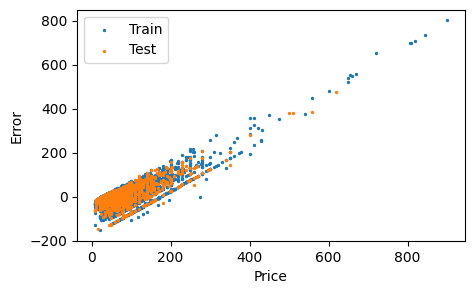

In [38]:
best_dt_model = tree.DecisionTreeRegressor(
    max_depth=8,
    min_samples_split=225
)
plot_metrics(best_dt_model, X_train_tot, y_train_tot, X_test, y_test)

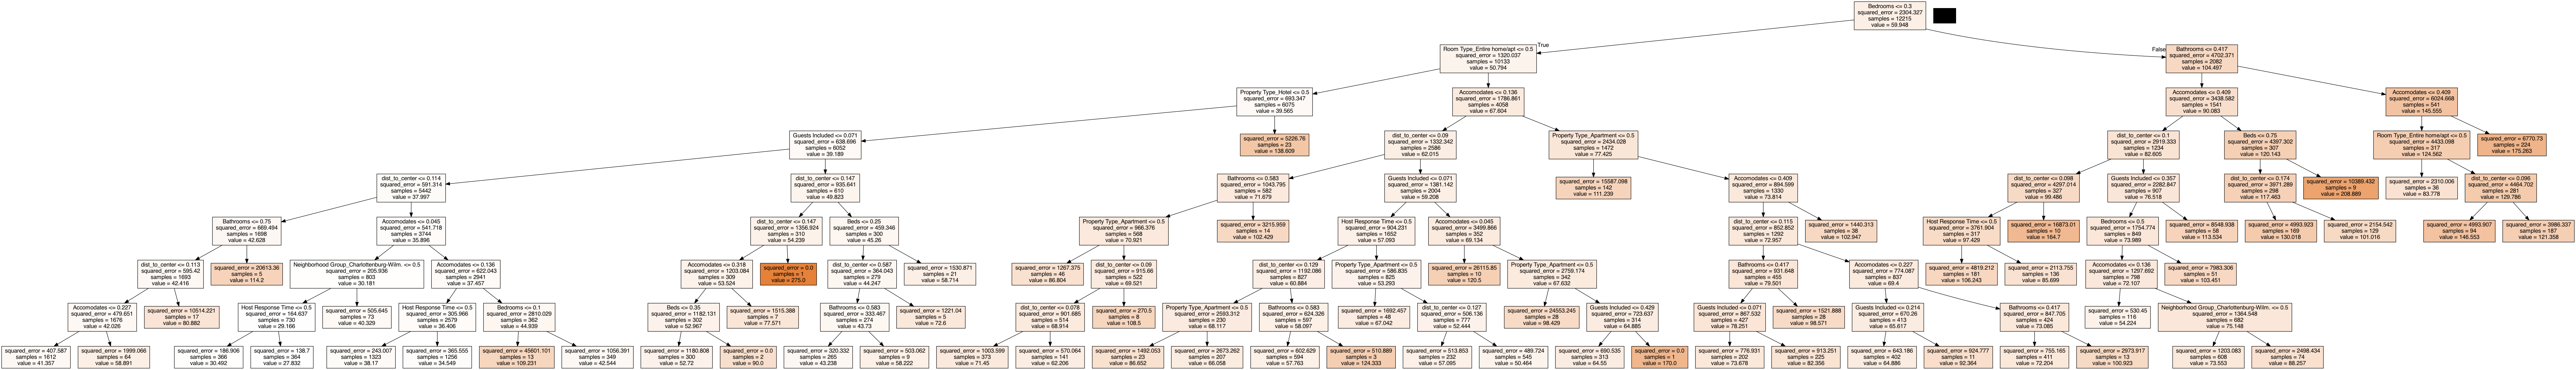

In [49]:
create_tree_graph_png(best_dt_model, X_train.columns)

### Random Forests

In [23]:
from sklearn.ensemble import RandomForestRegressor

pgrid = {
    "max_depth": range(4, 15, 2),
    "n_estimators": range(500, 900, 100),
    "min_samples_split": range(50, 500, 50)
}
best_random_forest_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    dt = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        min_samples_split=100,
        max_depth=params["max_depth"]
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    if mean_squared_error(y_val, y_pred) < mse:
        best_random_forest_params = dt.get_params()
        mse = mean_squared_error(y_val, y_pred)

print("min_samples_split: ", best_random_forest_params["min_samples_split"])
print("max_depth: ", best_random_forest_params["max_depth"])
print("n_estimators: ", best_random_forest_params["n_estimators"])

100%|██████████| 216/216 [29:15<00:00,  8.13s/it]

min_samples_split:  100
max_depth:  12
n_estimators:  500


Mean Squared Error:  1137.87
Mean Absolute Error: 20.61 €
Relative Absolute Error:  67.2 %
Quantile 1 :  -15.68  euros
Quantile 3 :  8.8  euros


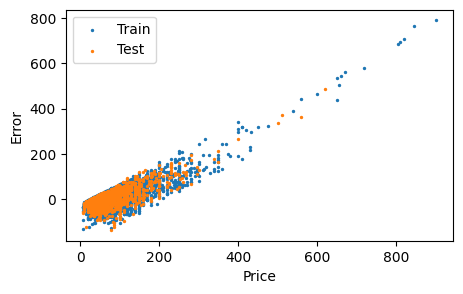

In [50]:
rforest = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=100,
    max_depth=12
)
plot_metrics(rforest, X_train_tot, y_train_tot, X_test, y_test)

### Bagging

In [57]:
from sklearn.ensemble import BaggingRegressor

pgrid = {
    "max_samples": [k/10 for k in range(1, 10)],
    "max_features": [k/10 for k in range(1, 10)],
}
best_bagging_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    dt = BaggingRegressor(
        base_estimator=tree.DecisionTreeRegressor(),
        max_samples=params["max_samples"],
        max_features=params["max_features"],
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    if mean_squared_error(y_val, y_pred) < mse:
        best_bagging_params = dt.get_params()
        mse = mean_squared_error(y_val, y_pred)

print("max_samples: ", best_bagging_params["max_samples"])
print("max_features: ", best_bagging_params["max_features"])

100%|██████████| 81/81 [00:09<00:00,  8.72it/s]

max_samples:  0.1
max_features:  0.6


Mean Squared Error:  1373.09
Mean Absolute Error: 22.65 €
Relative Absolute Error:  73.8 %
Quantile 1 :  -17.43  euros
Quantile 3 :  9.85  euros


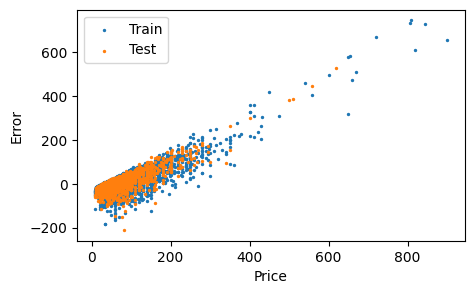

In [58]:
bagging = BaggingRegressor(
    base_estimator=tree.DecisionTreeRegressor(),
    max_samples=0.1,
    max_features=0.6,
)
plot_metrics(bagging, X_train_tot, y_train_tot, X_test, y_test)

### Gradient Boosting

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

pgrid = {
    "learning_rate": [0.005, 0.01, 0.015],
    "n_estimators": range(500, 600, 20),
    "min_samples_split": range(50, 150, 20)
}
best_gboosting_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    dt = GradientBoostingRegressor(
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        min_samples_split=params["min_samples_split"]
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    if mean_squared_error(y_val, y_pred) < mse:
        best_gboosting_params = dt.get_params()
        mse = mean_squared_error(y_val, y_pred)

print("learning_rate: ", best_gboosting_params["learning_rate"])
print("n_estimators: ", best_gboosting_params["n_estimators"])
print("min_samples_split: ", best_gboosting_params["min_samples_split"])

100%|██████████| 75/75 [05:53<00:00,  4.71s/it]

learning_rate:  0.015
n_estimators:  520
min_samples_split:  70


Mean Squared Error:  1116.14
Mean Absolute Error: 20.25 €
Relative Absolute Error:  66.0 %
Quantile 1 :  -15.26  euros
Quantile 3 :  8.27  euros


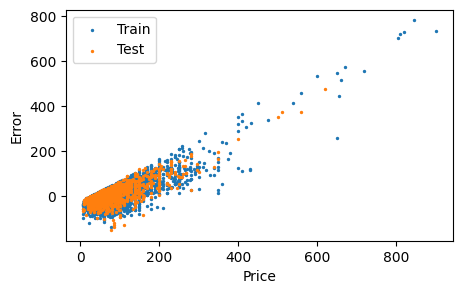

In [64]:
gboosting = GradientBoostingRegressor(
    learning_rate=0.015,
    n_estimators=520,
    min_samples_split=70
)
plot_metrics(gboosting, X_train_tot, y_train_tot, X_test, y_test)

### AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostRegressor

pgrid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "n_estimators": range(300, 500, 50)
}
best_adaboost_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    dt = AdaBoostRegressor(
        tree.DecisionTreeRegressor(),
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        loss='square'
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    if mean_squared_error(y_val, y_pred) < mse:
        best_adaboost_params = dt.get_params()
        mse = mean_squared_error(y_val, y_pred)

print("learning_rate: ", best_adaboost_params["learning_rate"])
print("n_estimators: ", best_adaboost_params["n_estimators"])

100%|██████████| 20/20 [04:46<00:00, 14.34s/it]

learning_rate:  1
n_estimators:  350


Mean Squared Error:  1367.63
Mean Absolute Error: 22.12 €
Relative Absolute Error:  72.1 %
Quantile 1 :  -18.0  euros
Quantile 3 :  10.0  euros


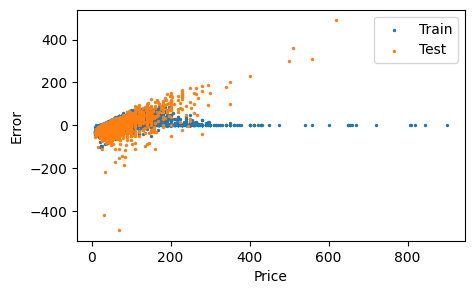

In [66]:
adaboost = AdaBoostRegressor(
    tree.DecisionTreeRegressor(),
    learning_rate=1,
    n_estimators=350
)
plot_metrics(adaboost, X_train_tot, y_train_tot, X_test, y_test)

XGBoost

In [68]:
import xgboost as xgb

# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

pgrid = {
    'colsample_bytree': [0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'max_depth': range(5, 30, 5),
    'subsample': [0.2, 0.4, 0.6, 0.8]
}

best_xgboost_params = {}
mse = 100000000

for params in tqdm(ParameterGrid(pgrid)):
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        max_depth=params["max_depth"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        learning_rate=params["learning_rate"],
        alpha=10
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    if mean_squared_error(y_val, y_pred) < mse:
        best_xgboost_params = xgb_model.get_params()
        mse = mean_squared_error(y_val, y_pred)

print("max_depth: ", best_xgboost_params["max_depth"])
print("subsample: ", best_xgboost_params["subsample"])
print("colsample_bytree: ", best_xgboost_params["colsample_bytree"])
print("learning_rate: ", best_xgboost_params["learning_rate"])

100%|██████████| 320/320 [04:00<00:00,  1.33it/s]

max_depth:  5
subsample:  0.6
colsample_bytree:  0.3
learning_rate:  0.1


Mean Squared Error:  1105.91
Mean Absolute Error: 20.36 €
Relative Absolute Error:  66.4 %
Quantile 1 :  -15.51  euros
Quantile 3 :  8.48  euros


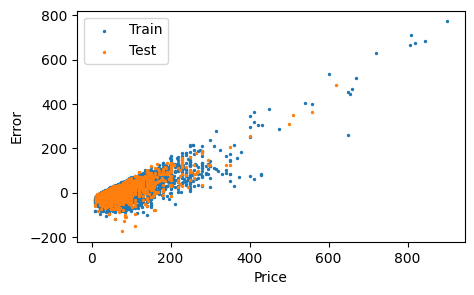

In [80]:
xgboost = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    max_depth=5,
    subsample=0.6,
    colsample_bytree=0.3,
    learning_rate=0.1,
    alpha=10
)
plot_metrics(xgboost, X_train_tot, y_train_tot, X_test, y_test)